<a href="https://colab.research.google.com/github/dton24/apache_spark_project/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression

**We are are going predict whether an app will get over 1,000,000 installs**

In [ ]:
#! pip install pyspark

In [ ]:
# Import necessary packages
import os
from pyspark.sql import SparkSession
import pyspark.pandas as ps

In [ ]:
# Read the CSV file directly with Pandas-on-Spark
df = ps.read_csv('dataset_with_clusters.csv', header=0)

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


## Preprocessing

**Explore Columns**

In [ ]:
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Android Ver,Market Segment9,Market Segment10,Market Segment11
0,ART_AND_DESIGN,3.2,55.0,2.7,5000,Free,0.0,Everyone,4.2 and up,Standard Performers,Standard Performers,Standard Performers
1,ART_AND_DESIGN,3.4,486.0,5.9,100000,Free,0.0,Everyone,5.0 and up,Standard Performers,Standard Performers,Standard Performers
2,ART_AND_DESIGN,3.8,178.0,19.0,50000,Free,0.0,Everyone,4.0.3 and up,Standard Performers,Standard Performers,Standard Performers
3,ART_AND_DESIGN,3.8,2206.0,1.2,100000,Free,0.0,Everyone,4.1 and up,Standard Performers,Standard Performers,Standard Performers
4,ART_AND_DESIGN,3.8,564.0,9.2,100000,Free,0.0,Everyone,4.1 and up,Standard Performers,Standard Performers,Standard Performers


**Add the new column with binary values (1 or 0)**

In [ ]:
df['Installations_One_Million_Or_Less'] = df['Installs'].apply(lambda x: 1 if x > 1_000_000 else 0)

In [ ]:
df['Installations_One_Million_Or_Less'].value_counts()

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


0    5326
1    1329
Name: Installations_One_Million_Or_Less, dtype: int64

### Feature Engineering

**Drop Unnecessary Columns**

In [ ]:
df = df.drop(columns = ['Installs', 'Market Segment9', 'Market Segment10', 'Market Segment11'])

*We drop Installs because we created a new installs column with binary because it's our dependent variables. We dropped the Market Segments (clusters we created in the other notebook) because it is already represented by the numerical columns.*

In [ ]:
df = df.drop(columns = 'Type')

*We drop the type columns because it is already represented by price**

In [ ]:
df.head()

,Category,Rating,Reviews,Size,Price,Content Rating,Android Ver,Installations_One_Million_Or_Less
0,ART_AND_DESIGN,3.2,55.0,2.7,0.0,Everyone,4.2 and up,0
1,ART_AND_DESIGN,3.4,486.0,5.9,0.0,Everyone,5.0 and up,0
2,ART_AND_DESIGN,3.8,178.0,19.0,0.0,Everyone,4.0.3 and up,0
3,ART_AND_DESIGN,3.8,2206.0,1.2,0.0,Everyone,4.1 and up,0
4,ART_AND_DESIGN,3.8,564.0,9.2,0.0,Everyone,4.1 and up,0


**View Updated Columns**

In [ ]:
df.shape

(6655, 8)

In [ ]:
df.head()

,Category,Rating,Reviews,Size,Price,Content Rating,Android Ver,Installations_One_Million_Or_Less
0,ART_AND_DESIGN,3.2,55.0,2.7,0.0,Everyone,4.2 and up,0
1,ART_AND_DESIGN,3.4,486.0,5.9,0.0,Everyone,5.0 and up,0
2,ART_AND_DESIGN,3.8,178.0,19.0,0.0,Everyone,4.0.3 and up,0
3,ART_AND_DESIGN,3.8,2206.0,1.2,0.0,Everyone,4.1 and up,0
4,ART_AND_DESIGN,3.8,564.0,9.2,0.0,Everyone,4.1 and up,0


**Correlation Matrix Analysis**

In [ ]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Display the result
print(corr_matrix)

                                     Rating   Reviews      Size     Price  Installations_One_Million_Or_Less
Rating                             1.000000  0.112038  0.033700  0.018085                           0.081864
Reviews                            0.112038  1.000000  0.207670 -0.044654                           0.491323
Size                               0.033700  0.207670  1.000000 -0.003879                           0.223547
Price                              0.018085 -0.044654 -0.003879  1.000000                          -0.086760
Installations_One_Million_Or_Less  0.081864  0.491323  0.223547 -0.086760                           1.000000


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


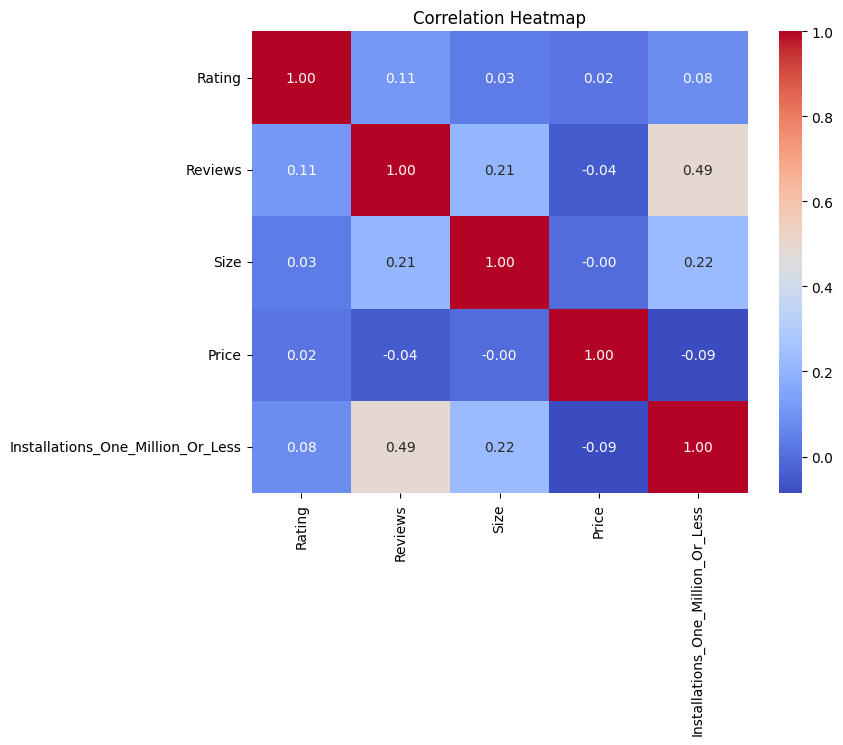

In [ ]:
# Necessary imports
import pyspark.pandas as ps
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to pandas DataFrame for visualization
corr_matrix_pd = corr_matrix.to_pandas()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_pd, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

*As we can see, there are no signs of multicollinearity between out numerical variables. The correlations all fall under 0.5, meaning there are no strong relationships between every 2 columns*

**Group Android Ver column into more general groups to prevent Overfitting**

In [ ]:
df['Android Ver'].unique()

0           2.0.1 and up
1             4.1 and up
2             4.4 and up
3           2.3.3 and up
4              5.0 - 6.0
5           4.0.3 and up
6            7.0 - 7.1.1
7          4.0.3 - 7.1.1
8             7.0 and up
9             7.1 and up
10            3.2 and up
11            1.0 and up
12            6.0 and up
13            4.3 and up
14            5.1 and up
15            3.0 and up
16            3.1 and up
17            4.0 and up
18            1.6 and up
19            2.1 and up
20            2.0 and up
21           4.4W and up
22    Varies with device
23            1.5 and up
24            2.2 and up
25            5.0 and up
26            2.3 and up
27            8.0 and up
28             5.0 - 8.0
29            4.2 and up
Name: Android Ver, dtype: object

In [ ]:
df['Android Ver'].value_counts()

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


4.1 and up            1674
4.0.3 and up          1067
4.0 and up             975
4.4 and up             677
2.3 and up             511
5.0 and up             419
4.2 and up             280
2.3.3 and up           213
3.0 and up             188
4.3 and up             169
2.2 and up             146
2.1 and up              82
Varies with device      46
6.0 and up              39
7.0 and up              35
1.6 and up              34
3.2 and up              28
2.0 and up              20
5.1 and up              14
1.5 and up               8
3.1 and up               7
2.0.1 and up             5
4.4W and up              5
8.0 and up               5
4.0.3 - 7.1.1            2
5.0 - 8.0                2
5.0 - 6.0                1
7.0 - 7.1.1              1
7.1 and up               1
1.0 and up               1
Name: Android Ver, dtype: int64

*Groupings*
- 1.0 to 3.0 and Up: For "and up" versions from 1.0 to 3.0.
- 3.1 to 5.0 and Up: For "and up" versions from 3.1 to 5.0.
- 5.1 to 8.0 and Up: For "and up" versions from 5.1 to 8.0.
- 5.0 to 8.0: For specific ranges from 5.0 to 8.0.
- Varies with Device: Special handling for Varies with device.

In [ ]:
# Mapping function for grouping
def map_android_version(version):
    if version == 'Varies with device':
        return 'Varies with Device'
    elif 'and up' in version:
        major_version = float(version.split()[0].split('.')[0])
        if major_version <= 3:
            return '1 to 3 and Up'
        elif major_version <= 5:
            return '3 to 5 and Up'
        elif major_version <= 8:
            return '5_1 to 8 and Up'
    elif version in ['5.0 - 6.0', '7.0 - 7.1.1', '4.0.3 - 7.1.1', '5.0 - 8.0']:
        return '5 to 8'
    else:
        return version

# Creating new column
df['Android Version Requirements'] = df['Android Ver'].apply(map_android_version)

In [ ]:
df.head()

,Category,Rating,Reviews,Size,Price,Content Rating,Android Ver,Installations_One_Million_Or_Less,Android Version Requirements
0,ART_AND_DESIGN,3.2,55.0,2.7,0.0,Everyone,4.2 and up,0,3 to 5 and Up
1,ART_AND_DESIGN,3.4,486.0,5.9,0.0,Everyone,5.0 and up,0,3 to 5 and Up
2,ART_AND_DESIGN,3.8,178.0,19.0,0.0,Everyone,4.0.3 and up,0,3 to 5 and Up
3,ART_AND_DESIGN,3.8,2206.0,1.2,0.0,Everyone,4.1 and up,0,3 to 5 and Up
4,ART_AND_DESIGN,3.8,564.0,9.2,0.0,Everyone,4.1 and up,0,3 to 5 and Up


In [ ]:
# View Unique Groups
df['Android Version Requirements'].unique()

0                5 to 8
1         3 to 5 and Up
2    Varies with Device
3         1 to 3 and Up
4       5_1 to 8 and Up
Name: Android Version Requirements, dtype: object

In [ ]:
# View Value Counts for Each Grouping
df['Android Version Requirements'].value_counts()

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


3 to 5 and Up         5280
1 to 3 and Up         1243
5_1 to 8 and Up         80
Varies with Device      46
5 to 8                   6
Name: Android Version Requirements, dtype: int64

In [ ]:
# Drop old Android Ver column
df = df.drop(columns = 'Android Ver')

In [ ]:
df.head()

,Category,Rating,Reviews,Size,Price,Content Rating,Installations_One_Million_Or_Less,Android Version Requirements
0,ART_AND_DESIGN,3.2,55.0,2.7,0.0,Everyone,0,3 to 5 and Up
1,ART_AND_DESIGN,3.4,486.0,5.9,0.0,Everyone,0,3 to 5 and Up
2,ART_AND_DESIGN,3.8,178.0,19.0,0.0,Everyone,0,3 to 5 and Up
3,ART_AND_DESIGN,3.8,2206.0,1.2,0.0,Everyone,0,3 to 5 and Up
4,ART_AND_DESIGN,3.8,564.0,9.2,0.0,Everyone,0,3 to 5 and Up


**Group Category into more General Groups to Prevent Overfitting**

In [ ]:
df['Category'].unique()

0                  EVENTS
1                  COMICS
2                  SPORTS
3                 WEATHER
4           VIDEO_PLAYERS
5       AUTO_AND_VEHICLES
6               PARENTING
7           ENTERTAINMENT
8         PERSONALIZATION
9      HEALTH_AND_FITNESS
10       TRAVEL_AND_LOCAL
11    BOOKS_AND_REFERENCE
12         FOOD_AND_DRINK
13            PHOTOGRAPHY
14               BUSINESS
15                 FAMILY
16               SHOPPING
17         HOUSE_AND_HOME
18                   GAME
19              EDUCATION
20           PRODUCTIVITY
21                  TOOLS
22              LIFESTYLE
23     NEWS_AND_MAGAZINES
24                MEDICAL
25          COMMUNICATION
26    MAPS_AND_NAVIGATION
27                 DATING
28     LIBRARIES_AND_DEMO
29                 BEAUTY
30                 SOCIAL
31                FINANCE
32         ART_AND_DESIGN
Name: Category, dtype: object

- Media & Entertainment: VIDEO_PLAYERS, PHOTOGRAPHY, BOOKS_AND_REFERENCE, ENTERTAINMENT, COMICS, GAME, LIBRARIES_AND_DEMO
- Lifestyle & Personal: FOOD_AND_DRINK, LIFESTYLE, BEAUTY, HEALTH_AND_FITNESS, SHOPPING, TRAVEL_AND_LOCAL, HOUSE_AND_HOME, AUTO_AND_VEHICLES, FINANCE, MEDICAL, ART_AND_DESIGN
- Utilities & Productivity: TOOLS, PRODUCTIVITY, PERSONALIZATION, BUSINESS
- Communication & Social: SOCIAL, DATING, COMMUNICATION, EVENTS, NEWS_AND_MAGAZINES
- Education & Family: EDUCATION, PARENTING, FAMILY
- Navigation & Maps: MAPS_AND_NAVIGATION, WEATHER, SPORTS

In [ ]:
# Define the refined mapping
category_mapping = {
    'VIDEO_PLAYERS': 'Media & Entertainment',
    'PHOTOGRAPHY': 'Media & Entertainment',
    'BOOKS_AND_REFERENCE': 'Media & Entertainment',
    'ENTERTAINMENT': 'Media & Entertainment',
    'COMICS': 'Media & Entertainment',
    'GAME': 'Media & Entertainment',
    'LIBRARIES_AND_DEMO': 'Media & Entertainment',
    'FOOD_AND_DRINK': 'Lifestyle & Personal',
    'LIFESTYLE': 'Lifestyle & Personal',
    'BEAUTY': 'Lifestyle & Personal',
    'HEALTH_AND_FITNESS': 'Lifestyle & Personal',
    'SHOPPING': 'Lifestyle & Personal',
    'TRAVEL_AND_LOCAL': 'Lifestyle & Personal',
    'HOUSE_AND_HOME': 'Lifestyle & Personal',
    'AUTO_AND_VEHICLES': 'Lifestyle & Personal',
    'ART_AND_DESIGN': 'Lifestyle & Personal',
    'FINANCE': 'Lifestyle & Personal',
    'MEDICAL': 'Lifestyle & Personal',
    'TOOLS': 'Utilities & Productivity',
    'PRODUCTIVITY': 'Utilities & Productivity',
    'PERSONALIZATION': 'Utilities & Productivity',
    'BUSINESS': 'Utilities & Productivity',
    'SOCIAL': 'Communication & Social',
    'DATING': 'Communication & Social',
    'COMMUNICATION': 'Communication & Social',
    'EVENTS': 'Communication & Social',
    'NEWS_AND_MAGAZINES': 'Communication & Social',
    'EDUCATION': 'Education & Family',
    'PARENTING': 'Education & Family',
    'FAMILY': 'Education & Family',
    'MAPS_AND_NAVIGATION': 'Navigation & Maps',
    'WEATHER': 'Navigation & Maps',
    'SPORTS': 'Navigation & Maps'
}

# Apply the refined mapping to the 'Category' column only
df['Category'] = df['Category'].map(category_mapping)

In [ ]:
df['Category'].value_counts()

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


Education & Family          1610
Lifestyle & Personal        1480
Media & Entertainment       1370
Utilities & Productivity    1179
Communication & Social       653
Navigation & Maps            363
Name: Category, dtype: int64

### Normalize Numerical Columns and Create Dummies

#### Normalization

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
import pyspark.pandas as ps

numeric_df = df[['Rating', 'Reviews', 'Size',  'Price']]

numeric_df.head()

,Rating,Reviews,Size,Price
0,3.2,55.0,2.7,0.0
1,3.4,486.0,5.9,0.0
2,3.8,178.0,19.0,0.0
3,3.8,2206.0,1.2,0.0
4,3.8,564.0,9.2,0.0


In [ ]:
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, ArrayType

# Initialize a Spark session
spark = SparkSession.builder.master("local").appName("Normalization").getOrCreate()

# Assuming numeric_df is a pandas on Spark DataFrame
inputCols = ['Rating', 'Reviews', 'Size', 'Price']

# Convert numeric_df to a PySpark DataFrame
numeric_spark_df = numeric_df.to_spark(index_col='index')

# Combine columns into a vector
vectorAssembler = VectorAssembler(inputCols=inputCols, outputCol='features')
numeric_spark_df = vectorAssembler.transform(numeric_spark_df)

# Apply StandardScaler to normalize features
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)
scaler_model = scaler.fit(numeric_spark_df)
scaled_df = scaler_model.transform(numeric_spark_df)

# Extract normalized values to replace the original columns
def extract_element(idx):
    return udf(lambda array: float(array[idx]), DoubleType())

for idx, col_name in enumerate(inputCols):
    scaled_df = scaled_df.withColumn(col_name, extract_element(idx)('scaled_features'))

# Drop intermediate columns
scaled_df = scaled_df.drop('features').drop('scaled_features')

# Convert back to pandas on Spark DataFrame
numeric_df = ps.DataFrame(scaled_df)

# Show the transformed DataFrame
print(numeric_df.head())



   index    Rating   Reviews      Size     Price
0      0 -2.194650 -0.276405 -0.907074 -0.174086
1      1 -1.761801 -0.274907 -0.751691 -0.174086
2      2 -0.896104 -0.275977 -0.115592 -0.174086
3      3 -0.896104 -0.268930 -0.979910 -0.174086
4      4 -0.896104 -0.274636 -0.591453 -0.174086


In [ ]:
numeric_df.drop(columns = 'index')

,Rating,Reviews,Size,Price
0,-2.194650,-0.276405,-0.907074,-0.174086
1,-1.761801,-0.274907,-0.751691,-0.174086
2,-0.896104,-0.275977,-0.115592,-0.174086
3,-0.896104,-0.268930,-0.979910,-0.174086
4,-0.896104,-0.274636,-0.591453,-0.174086
5,-0.679680,-0.276123,-0.814816,-0.174086
6,-0.679680,-0.273236,-0.358378,-0.174086
7,-0.463255,-0.276533,-0.863373,-0.174086
8,-0.463255,-0.275032,-0.358378,-0.174086
9,-0.463255,-0.274542,-0.581741,-0.174086


#### Get Dummies

**View df**

In [ ]:
df.head()

,Category,Rating,Reviews,Size,Price,Content Rating,Installations_One_Million_Or_Less,Android Version Requirements
0,Lifestyle & Personal,3.2,55.0,2.7,0.0,Everyone,0,3 to 5 and Up
1,Lifestyle & Personal,3.4,486.0,5.9,0.0,Everyone,0,3 to 5 and Up
2,Lifestyle & Personal,3.8,178.0,19.0,0.0,Everyone,0,3 to 5 and Up
3,Lifestyle & Personal,3.8,2206.0,1.2,0.0,Everyone,0,3 to 5 and Up
4,Lifestyle & Personal,3.8,564.0,9.2,0.0,Everyone,0,3 to 5 and Up


**Make new df called categorical_df with categorical columns**

In [ ]:
categorical_df = df[['Category','Content Rating', 'Android Version Requirements']]
categorical_df.head()

,Category,Content Rating,Android Version Requirements
0,Lifestyle & Personal,Everyone,3 to 5 and Up
1,Lifestyle & Personal,Everyone,3 to 5 and Up
2,Lifestyle & Personal,Everyone,3 to 5 and Up
3,Lifestyle & Personal,Everyone,3 to 5 and Up
4,Lifestyle & Personal,Everyone,3 to 5 and Up


**Create dummies**

In [ ]:
categorical_columns = ['Category', 'Content Rating', 'Android Version Requirements']
encoded_df = ps.get_dummies(categorical_df, columns=categorical_columns)

In [ ]:
encoded_df.head()

,Category_Communication & Social,Category_Education & Family,Category_Lifestyle & Personal,Category_Media & Entertainment,Category_Navigation & Maps,Category_Utilities & Productivity,Content Rating_Adults only 18+,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated,Android Version Requirements_1 to 3 and Up,Android Version Requirements_3 to 5 and Up,Android Version Requirements_5 to 8,Android Version Requirements_5_1 to 8 and Up,Android Version Requirements_Varies with Device
0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0


### Join Dummies and Normalized Data (Predictors)

In [ ]:
# Join the DataFrames using their natural index
merged_df = encoded_df.join(numeric_df, how='inner')

# Show the merged DataFrame
print(merged_df.head())


   Category_Communication & Social  Category_Education & Family  Category_Lifestyle & Personal  Category_Media & Entertainment  Category_Navigation & Maps  Category_Utilities & Productivity  Content Rating_Adults only 18+  Content Rating_Everyone  Content Rating_Everyone 10+  Content Rating_Mature 17+  Content Rating_Teen  Content Rating_Unrated  Android Version Requirements_1 to 3 and Up  Android Version Requirements_3 to 5 and Up  Android Version Requirements_5 to 8  Android Version Requirements_5_1 to 8 and Up  Android Version Requirements_Varies with Device  index    Rating   Reviews      Size     Price
0                                0                            0                              1                               0                           0                                  0                               0                        1                            0                          0                    0                       0                                      

In [ ]:
merged_df = merged_df.drop(columns = 'index')

## Model Partitioning, Training, and Testing

**Create X and y**

In [ ]:
X = merged_df
y = df['Installations_One_Million_Or_Less']

In [ ]:
print(X.head())
print(y.head())

   Category_Communication & Social  Category_Education & Family  Category_Lifestyle & Personal  Category_Media & Entertainment  Category_Navigation & Maps  Category_Utilities & Productivity  Content Rating_Adults only 18+  Content Rating_Everyone  Content Rating_Everyone 10+  Content Rating_Mature 17+  Content Rating_Teen  Content Rating_Unrated  Android Version Requirements_1 to 3 and Up  Android Version Requirements_3 to 5 and Up  Android Version Requirements_5 to 8  Android Version Requirements_5_1 to 8 and Up  Android Version Requirements_Varies with Device    Rating   Reviews      Size     Price
0                                0                            0                              1                               0                           0                                  0                               0                        1                            0                          0                    0                       0                                           0 

In [ ]:
# Convert to PySpark DataFrame and combine predictors with labels
X_spark = X.to_spark()
y_spark = y.to_frame(name='label').to_spark()
data_spark = X_spark.join(y_spark)

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


**Partitioning**

In [ ]:
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline


In [ ]:
# Train-Test Split
train_df, test_df = data_spark.randomSplit([0.7, 0.3], seed=42)

**Training**

In [ ]:
# VectorAssembler for feature vector
inputCols = X.columns.tolist()
vectorAssembler = VectorAssembler(inputCols=inputCols, outputCol='features')

In [ ]:
# Initialize Logistic Regression model
log_reg = LogisticRegression(featuresCol='features', labelCol='label')

# Create Pipeline
pipeline = Pipeline(stages=[vectorAssembler, log_reg])

In [ ]:
# Fit the model
model = pipeline.fit(train_df)

In [ ]:
# Predict on the test data
predictions = model.transform(test_df)
predictions.select('features', 'label', 'prediction').show()

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(21,[5,11,12,17,1...|    0|       0.0|
|(21,[5,11,12,17,1...|    0|       0.0|
|(21,[5,11,12,17,1...|    0|       0.0|
|(21,[5,11,12,17,1...|    0|       0.0|
|(21,[5,11,12,17,1...|    0|       0.0|
|(21,[5,11,12,17,1...|    0|       0.0|
|(21,[5,11,12,17,1...|    0|       0.0|
|(21,[5,11,12,17,1...|    0|       0.0|
|(21,[5,11,12,17,1...|    0|       0.0|
|(21,[5,11,12,17,1...|    0|       0.0|
|(21,[5,11,12,17,1...|    0|       0.0|
|(21,[5,11,12,17,1...|    0|       0.0|
|(21,[5,11,12,17,1...|    0|       0.0|
|(21,[5,11,12,17,1...|    0|       0.0|
|(21,[5,11,12,17,1...|    0|       0.0|
|(21,[5,11,12,17,1...|    0|       0.0|
|(21,[5,11,12,17,1...|    0|       0.0|
|(21,[5,11,12,17,1...|    0|       0.0|
|(21,[5,11,12,17,1...|    0|       0.0|
|(21,[5,11,12,17,1...|    0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Predict on training data
train_predictions = model.transform(train_df)
results_train = train_predictions.select('label', 'probability', 'prediction')

# Predict on test data
test_predictions = model.transform(test_df)
results_test = test_predictions.select('label', 'probability', 'prediction')

# Initialize evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label')

# Evaluate on training data
train_accuracy = evaluator.evaluate(results_train, {evaluator.metricName: 'accuracy'})
print(f'Training Accuracy: {train_accuracy}')

# Evaluate on test data
test_accuracy = evaluator.evaluate(results_test, {evaluator.metricName: 'accuracy'})
print(f'Test Accuracy: {test_accuracy}')

# Evaluate other metrics if needed (e.g., f1, weightedPrecision)
train_f1_score = evaluator.evaluate(results_train, {evaluator.metricName: 'f1'})
test_f1_score = evaluator.evaluate(results_test, {evaluator.metricName: 'f1'})

print(f'Training F1 Score: {train_f1_score}')
print(f'Test F1 Score: {test_f1_score}')


Training Accuracy: 0.8003341346699666
Test Accuracy: 0.8002220840292436


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

*Due to extremely long loading time, the F1 Score was not able to be displayed, however, the accuracy score for training set was displayed at 80.003% and test set is 80.002%. Our model is highly accurate and also does not overfit and performs well on new data*

In [ ]:
# Model is trained with a VectorAssembler
input_columns = vectorAssembler.getInputCols()  # Retrieve input feature names

# Access the logistic regression model from the pipeline
log_reg_model = model.stages[-1]  #  Logistic Regression is the last stage in the pipeline

# Get the coefficients and intercept from the logistic regression model
coefficients = log_reg_model.coefficients
intercept = log_reg_model.intercept

# Pair each feature name with its coefficient
feature_coefficients = zip(input_columns, coefficients)

# Print the feature-coefficient pairs
for feature, coefficient in feature_coefficients:
    print(f"{feature}: {coefficient}")

# Print the intercept
print("Intercept:", intercept)


Category_Communication & Social: -0.0005838342597387908
Category_Education & Family: -0.0001127587862139777
Category_Lifestyle & Personal: 7.980854562782953e-05
Category_Media & Entertainment: 0.0005370373965248815
Category_Navigation & Maps: 0.00024326621638405102
Category_Utilities & Productivity: -0.0002869406858449568
Content Rating_Adults only 18+: -0.001759895473856095
Content Rating_Everyone: 0.000880826616332885
Content Rating_Everyone 10+: 0.0003542509257485356
Content Rating_Mature 17+: -0.0014054945810496502
Content Rating_Teen: -0.0009172143441551952
Content Rating_Unrated: 0.009815924514990968
Android Version Requirements_1 to 3 and Up: -2.5091619434105118e-05
Android Version Requirements_3 to 5 and Up: -0.00010913835279056609
Android Version Requirements_5 to 8: -0.00164587377326457
Android Version Requirements_5_1 to 8 and Up: -0.001545158422419648
Android Version Requirements_Varies with Device: 0.0060444884922693015
Rating: -0.00011287280199122477
Reviews: 0.0002237615

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


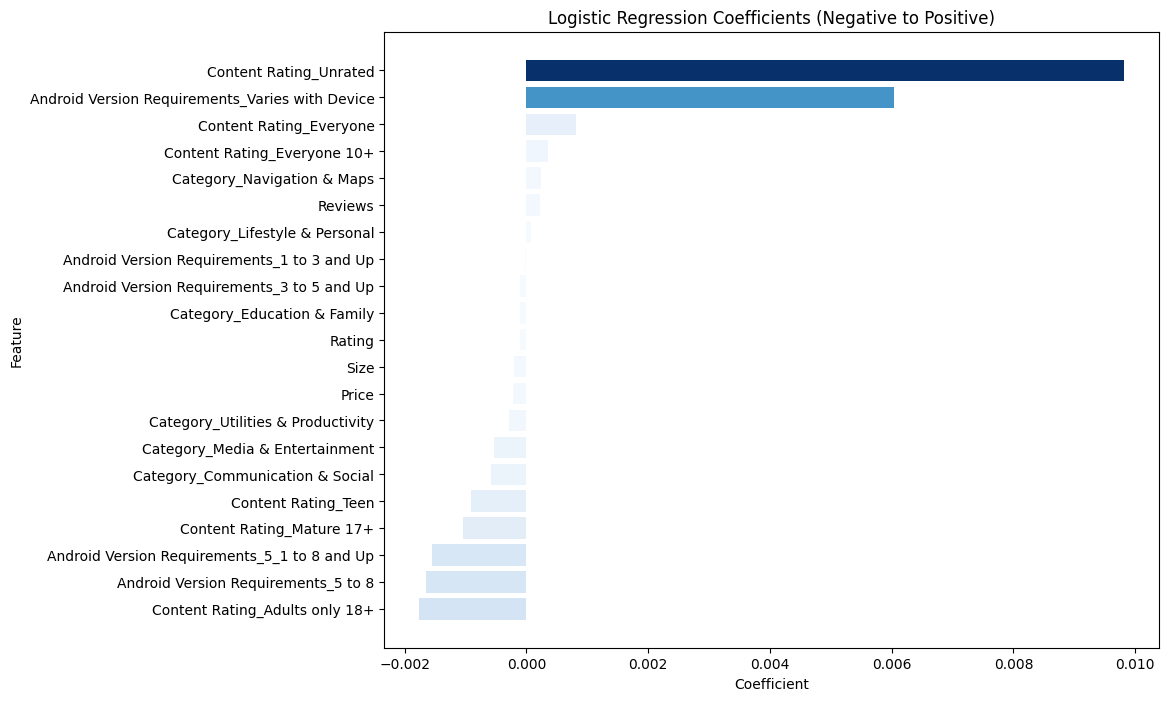

In [ ]:
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import numpy as np

# Example feature names and coefficients from a Spark Logistic Regression model
# Replace this with your actual data retrieval
ps_data = ps.DataFrame({
    'Feature': ["Category_Communication & Social", "Category_Education & Family",
                "Category_Lifestyle & Personal", "Category_Media & Entertainment",
                "Category_Navigation & Maps", "Category_Utilities & Productivity",
                "Content Rating_Adults only 18+", "Content Rating_Everyone",
                "Content Rating_Everyone 10+", "Content Rating_Mature 17+",
                "Content Rating_Teen", "Content Rating_Unrated",
                "Android Version Requirements_1 to 3 and Up",
                "Android Version Requirements_3 to 5 and Up",
                "Android Version Requirements_5 to 8", "Android Version Requirements_5_1 to 8 and Up",
                "Android Version Requirements_Varies with Device", "Rating", "Reviews", "Size", "Price"],
    'Coefficient': [-0.0005838342597387908, -0.0001127587862139777, 7.980854562782953e-05,
                    -0.0005370373965248815, 0.0002432662136845102, -0.0002869460858449568,
                    -0.001759895473856095, 0.000808826165332885, 0.0003542509275485356,
                    -0.001045945810496502, -0.0009172143441551952, 0.009815924514999698,
                    -2.5091619434105118e-05, -0.00010191383527905669, -0.001645873737326457,
                    -0.001545158422419648, 0.0060444884922693015, -0.00011287280199122477,
                    0.0002237615445232234, -0.0001974882206616083, -0.0002283911755322143]
})

# Sort coefficients from lowest (most negative) to highest (most positive)
sorted_ps = ps_data.sort_values(by='Coefficient', ascending=True)

# Extract features and coefficients for plotting
sorted_features = sorted_ps['Feature'].to_list()
sorted_coefficients = sorted_ps['Coefficient'].to_numpy()

# Generate color intensities based on absolute values of coefficients
norm_coefficients = np.abs(sorted_coefficients) / np.max(np.abs(sorted_coefficients))
colors = plt.cm.Blues(norm_coefficients)

# Create a bar plot
plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_coefficients, color=colors)
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Logistic Regression Coefficients (Negative to Positive)")
plt.show()
